# Case study: Aecert Robotics gaits gen

Aecert Robotics youtube channel covers a hexapod build and it mentions a new gait generation algorithm that allows on the fly transitions https://youtu.be/DKsyJYkdZ_o?si=0ym37QSEdOcEfFBf

With some google search it looks like code is here https://github.com/Ryan-Mirch/Aecerts_Hexapod_V1/blob/main/RC_V3/RC%20Code/src/Pages/GaitsPage.cpp

There is no license attached in the repo, which means now work can be reproduced, distributed or any derivative work can be created... according to https://docs.github.com/en/repositories/managing-your-repositorys-settings-and-features/customizing-your-repository/licensing-a-repository code in public repo can be forked and viewed

This notebook is just a case study of the code in original repo and is not a derivative work. All copyright to the code still belongs to 

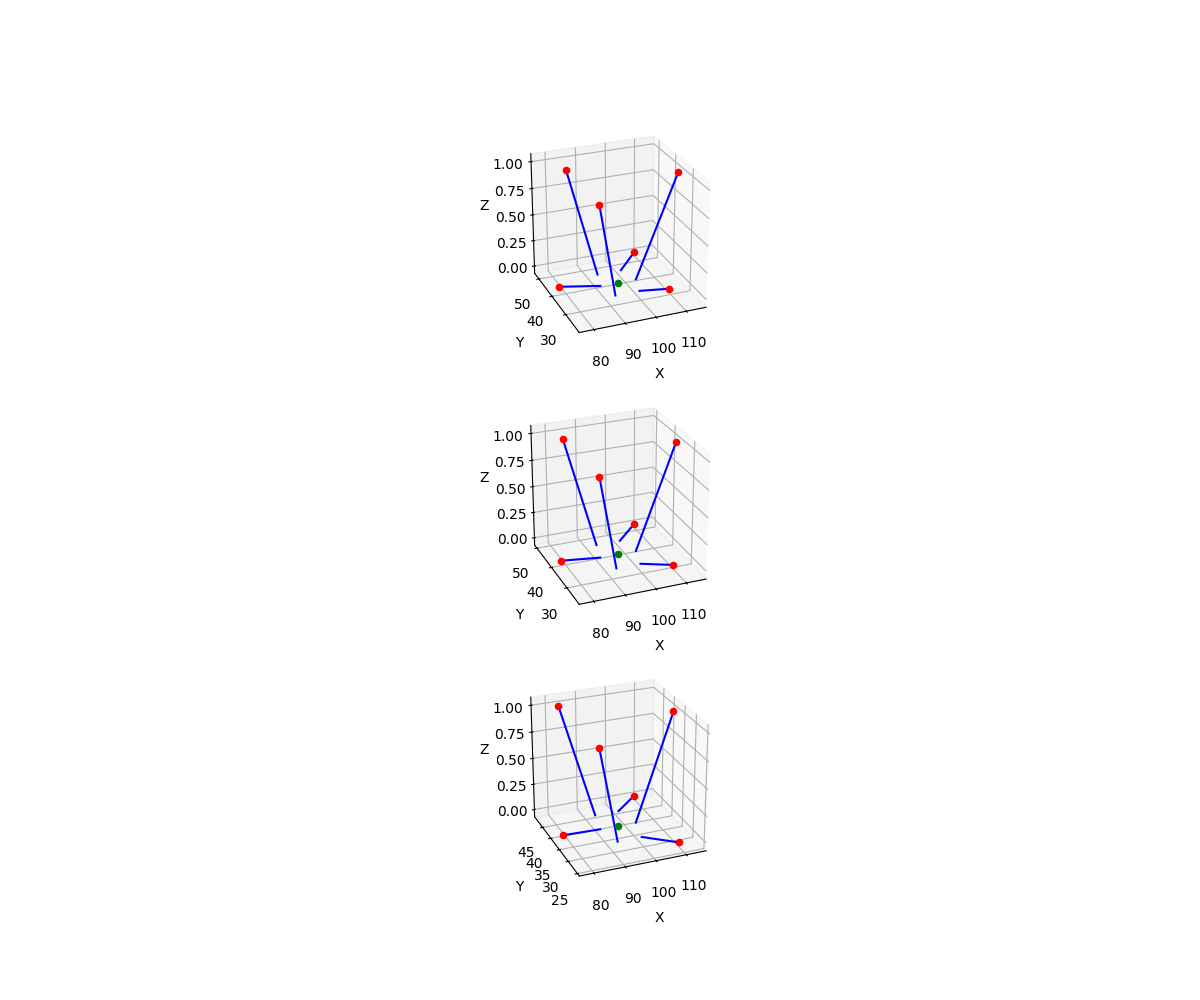

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact

# based on RC_V3/RC Code/include/Globals.h
class Gaits:
    TRI = 0
    RIPPLE = 1
    WAVE = 2
    QUAD = 3
    BI = 4
    HOP = 5

    gaitStrings = ["Tri", "Ripple", "Wave", "Quad", "Bi", "Hop"]
    gaitCount = len(gaitStrings)

    # based on RC_V3/RC Code/src/Globals.cpp
    @staticmethod
    def to_string(gait):
        if gait < 0 or gait >= len(Gaits.gaitStrings):
            raise ValueError(f"Invalid gait {gait}. Valid rang is 0-{Gaits.gaitCount-1} corresponding to {Gaits.gaitStrings}")
        return Gaits.gaitStrings[gait]

def lerp(a, b, t):
    return a + (b - a) * t

class GaitGen: # based on RC_V3/RC Code/src/Pages/GaitsPage.cpp
    def __init__(self, points=100, strideLength=9):
        self.points = points
        self.strideLength = strideLength

        legs_count = 6
        self.legAnimProgress = np.zeros(legs_count)

        self.legs = np.zeros((legs_count,3))
        self.legsCenter = np.zeros((legs_count,2))

        self.hovered = 0
        self.pushFraction = 0.5

        self.selectedGait = Gaits.TRI # It is global in original code, but is sufficient as member in notebook

        self.init()

    def init(self):
        self.hovered = self.selectedGait
        self.resetAnimation()

    def resetAnimation(self):
        if self.hovered == Gaits.TRI:
            self.legAnimProgress[0] = 0
            self.legAnimProgress[1] = self.points / 2
            self.legAnimProgress[2] = 0
            self.legAnimProgress[3] = self.points / 2
            self.legAnimProgress[4] = 0
            self.legAnimProgress[5] = self.points / 2

            self.pushFraction = 3.1 / 6.0
        elif self.hovered == Gaits.RIPPLE:
            self.legAnimProgress[0] = 0
            self.legAnimProgress[1] = (self.points / 6) * 4
            self.legAnimProgress[2] = (self.points / 6) * 2
            self.legAnimProgress[3] = (self.points / 6) * 5
            self.legAnimProgress[4] = (self.points / 6)
            self.legAnimProgress[5] = (self.points / 6) * 3

            self.pushFraction = 3.2 / 6.0
        elif self.hovered == Gaits.WAVE:
            self.legAnimProgress[0] = 0
            self.legAnimProgress[1] = (self.points / 6)
            self.legAnimProgress[2] = (self.points / 6) * 2
            self.legAnimProgress[3] = (self.points / 6) * 5
            self.legAnimProgress[4] = (self.points / 6) * 4
            self.legAnimProgress[5] = (self.points / 6) * 3

            self.pushFraction = 5.0 / 6.0
        elif self.hovered == Gaits.QUAD:
            self.legAnimProgress[0] = 0
            self.legAnimProgress[1] = (self.points / 3)
            self.legAnimProgress[2] = (self.points / 3) * 2
            self.legAnimProgress[3] = 0
            self.legAnimProgress[4] = (self.points / 3)
            self.legAnimProgress[5] = (self.points / 3) * 2

            self.pushFraction = 4.1 / 6.0
        elif self.hovered == Gaits.BI:
            self.legAnimProgress[0] = 0
            self.legAnimProgress[1] = (self.points / 3)
            self.legAnimProgress[2] = (self.points / 3) * 2
            self.legAnimProgress[3] = 0
            self.legAnimProgress[4] = (self.points / 3)
            self.legAnimProgress[5] = (self.points / 3) * 2

            self.pushFraction = 2.1 / 6.0
        elif self.hovered == Gaits.HOP:
            self.legAnimProgress[0] = 0
            self.legAnimProgress[1] = 0
            self.legAnimProgress[2] = 0
            self.legAnimProgress[3] = 0
            self.legAnimProgress[4] = 0
            self.legAnimProgress[5] = 0

            self.pushFraction = 3 / 6.0
        else:
            raise ValueError(f"Invalid gait {self.hovered}.")

        self.legsCenter[0] = np.array([-9, -5])
        self.legsCenter[1] = np.array([-12, 0])
        self.legsCenter[2] = np.array([-9, 5])
        self.legsCenter[3] = np.array([9, 5])
        self.legsCenter[4] = np.array([12, 0])
        self.legsCenter[5] = np.array([9, -5])

        for i in range(len(self.legs)):
            self.legs[i] = np.array([self.legsCenter[i][0], self.legsCenter[i][1], 1])

    def loop(self, ax=None):
        # Unused UI Code
        # if getButtonValue(A) == PRESSED:
        #     currentPage = mainMenuPage
        # drawPageHeader("< Home < Menu < ", "Gaits")
        # u8g2.setFont(FONT_TEXT_MONOSPACE)
        # u8g2.drawStr(115, 63, String(getRotaryEncoderTotalSpins()).c_str())

        # This is a rotary encoder used to change the gait, we would need a different control for the notebook
        # increment = 0
        # previousHovered = self.hovered
        # spins = getRotaryEncoderSpins()
        # if spins > 0:
        #     increment = 1
        # if spins < 0:
        #     increment = -1
        # self.hovered += increment
        # if self.hovered >= Gaits.gaitCount:
        #     self.hovered = Gaits.gaitCount - 1
        # elif self.hovered < 0:
        #     self.hovered = 0
        # if previousHovered != self.hovered:
        #     self.resetAnimation()
        # if getRotaryEncoderSwitchValue() == PRESSED:
        #     self.selectedGait = self.hovered

        # Unused UI Code
        # rowSpacing = 14
        # listYStart = 24
        # listLeftSpacing = 15
        #
        # if self.hovered >= 2:
        #     listYStart = listYStart - rowSpacing * (self.hovered - 2)

        # Unused UI Code
        # u8g2.setFont(FONT_TEXT)
        # for i in range(Gaits.gaitCount):
        #     if self.hovered >= i + 3:
        #         continue
        #     print(f"{listLeftSpacing}, {listYStart + rowSpacing * i}, {Gaits.gaitStrings[i]}")
        #     if self.selectedGait == i:
        #         print(">")
        #     if self.hovered == i:
        #         print("RFrame")

        # Hexapod Visualizer
        for i in range(6):
            self.legAnimProgress[i] += 8
            if self.legAnimProgress[i] >= self.points:
                self.legAnimProgress[i] = self.legAnimProgress[i] - self.points

        pushPoints = self.points * self.pushFraction
        raisePoints = self.points - pushPoints

        for i in range(6):
            if self.legAnimProgress[i] < pushPoints:
                self.legs[i][1] = self.legsCenter[i][1] + lerp(-self.strideLength / 2, self.strideLength / 2, self.legAnimProgress[i] / (pushPoints))
                self.legs[i][2] = 1
            else:
                self.legs[i][1] = self.legsCenter[i][1] + lerp(self.strideLength / 2, -self.strideLength / 2, (self.legAnimProgress[i] - pushPoints) / raisePoints)
                self.legs[i][2] = 0

        self.drawHexapod(ax, np.array([96, 37]), self.legs[0], self.legs[1], self.legs[2], self.legs[3], self.legs[4], self.legs[5])

    def drawHexapod(self, ax, center, leg1, leg2, leg3, leg4, leg5, leg6):
        if not ax:
            return

        leg1Base = center + np.array([-4, -6])
        leg2Base = center + np.array([-6, 0])
        leg3Base = center + np.array([-4, 6])
        leg4Base = center + np.array([4, 6])
        leg5Base = center + np.array([6, 0])
        leg6Base = center + np.array([4, -6])

        leg1 = leg1 + np.array([leg1Base[0], leg1Base[1], 0])
        leg2 = leg2 + np.array([leg2Base[0], leg2Base[1], 0])
        leg3 = leg3 + np.array([leg3Base[0], leg3Base[1], 0])
        leg4 = leg4 + np.array([leg4Base[0], leg4Base[1], 0])
        leg5 = leg5 + np.array([leg5Base[0], leg5Base[1], 0])
        leg6 = leg6 + np.array([leg6Base[0], leg6Base[1], 0])

        # drawLine(leg1Base[0], leg1Base[1], leg1[0], leg1[1])
        # drawLine(leg2Base[0], leg2Base[1], leg2[0], leg2[1])
        # drawLine(leg3Base[0], leg3Base[1], leg3[0], leg3[1])
        # drawLine(leg4Base[0], leg4Base[1], leg4[0], leg4[1])
        # drawLine(leg5Base[0], leg5Base[1], leg5[0], leg5[1])
        # drawLine(leg6Base[0], leg6Base[1], leg6[0], leg6[1])
        ax.plot([leg1Base[0], leg1[0]], [leg1Base[1], leg1[1]], [0, leg1[2]], c='b')
        ax.plot([leg2Base[0], leg2[0]], [leg2Base[1], leg2[1]], [0, leg2[2]], c='b')
        ax.plot([leg3Base[0], leg3[0]], [leg3Base[1], leg3[1]], [0, leg3[2]], c='b')
        ax.plot([leg4Base[0], leg4[0]], [leg4Base[1], leg4[1]], [0, leg4[2]], c='b')
        ax.plot([leg5Base[0], leg5[0]], [leg5Base[1], leg5[1]], [0, leg5[2]], c='b')
        ax.plot([leg6Base[0], leg6[0]], [leg6Base[1], leg6[1]], [0, leg6[2]], c='b')

        # drawHexapodBody(center);
        ax.scatter(center[0], center[1], 0, c='g', marker='o')

        # drawHexapodFoot(leg1[0], leg1[1], leg1[2] == 1)
        # drawHexapodFoot(leg2[0], leg2[1], leg2[2] == 1)
        # drawHexapodFoot(leg3[0], leg3[1], leg3[2] == 1)
        # drawHexapodFoot(leg4[0], leg4[1], leg4[2] == 1)
        # drawHexapodFoot(leg5[0], leg5[1], leg5[2] == 1)
        # drawHexapodFoot(leg6[0], leg6[1], leg6[2] == 1)
        ax.scatter(leg1[0], leg1[1], leg1[2], c='r', marker='o')
        ax.scatter(leg2[0], leg2[1], leg2[2], c='r', marker='o')
        ax.scatter(leg3[0], leg3[1], leg3[2], c='r', marker='o')
        ax.scatter(leg4[0], leg4[1], leg4[2], c='r', marker='o')
        ax.scatter(leg5[0], leg5[1], leg5[2], c='r', marker='o')
        ax.scatter(leg6[0], leg6[1], leg6[2], c='r', marker='o')

%matplotlib widget

fig, axes = plt.subplots(
    3,
    1,
    figsize=(12, 10),
    subplot_kw={
        'projection': '3d',
        'aspect': 'equal',
        # 'xlim': (0, 128),
        # 'ylim': (0, 64),
        'xlabel': 'X',
        'ylabel': 'Y',
        'zlabel': 'Z',

        'elev': 25,
        'azim': -112,
    },
)

gait = GaitGen()
gait.loop(axes[0])
gait.loop(axes[1])
gait.loop(axes[2])